In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

url = 'http://th-www.if.uj.edu.pl/~erichter/dydaktyka/Dydaktyka2019/DataScience-2019/kc_house_data.csv.zip'
house_df = pd.read_csv(url)


## 1. Linear Regression. A bit of formalism

Let's have a data consisting of $n$ samples. These samples are $(m+1)$ - dimensional vectors, where first $m$ dimensions are called features (explanatory variables) and will be used to predict the last dimension which is called regressand (dependent variable). 

We will have therefore a $n \times m$ matrix **$X$** (called feature matrix) and vector **$y$** of lenght $n$. 

In our simple example, living squarefeet is a feature, house's price is regressand and the data consists of $100$ samples. It forms $100 \times 1$ feature matrix **$X$** and vector **$y$** of length $100$.

In [3]:
X = house_df.sqft_living.values.reshape(-1,1)[:100]
y = house_df.price.values.reshape(-1,1)[:100]
print(np.shape(X))
print(np.shape(y))

(100, 1)
(100, 1)


Linear regression approach tries to find a vector **$b$** which minimizes the cost function 

$$f_{y}(b) = \dfrac{|Xb - y|^2}{n}, $$

where **$|\cdot|$** is euclidean norm and **$Xb$** is simple matrix multiplication (vector is also a matrix). 

Geometrically (and roughly) speaking, we are determining a line which minimizes the cumulative distance to all the points. 

When such a vector **$b$** is found, we can predict values **$y$** for given features **$X$** by calculating **$Xb$**. We have therefore 

$$y_{pred} = Xb, \\ f_{y}(b) = \dfrac{|y_{pred} - y|^2}{n}. $$

## Exercise 1
a) Create functions *predict(b, X)* and *cost(y_pred, y_true)* implementing theory above.  All inputs should be numpy arrays (take care of dimension scalability!)  
b) For our data **$X,y$**, plot cost as the function of **$b$** (which is one dimensional vector). Plot the line with best slope among  evaluated with *cost* function.

In [54]:
#a)
def predict(b, X):
    return X @ b

def cost(y_pred, y_true):
    return np.mean([np.power(y_p - y,2) for y_p, y in zip(y_pred, y_true)])



#short test:
test_b = np.array([[1],[1],[1]])
test_X = np.array([[1,2,3],[2,5,4],[3,4,5],[4,5,7]])
test_y = np.array([[1],[2],[3],[4]])

print(predict(test_b, test_X))
print(cost(predict(test_b, test_X),test_y))

[[ 6]
 [11]
 [12]
 [16]]
82.75


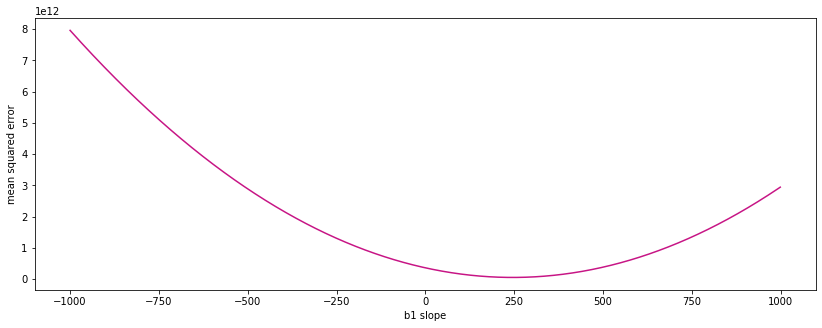

In [5]:
# b)
b1s = [[i] for i in range(-1000, 1000)]
costs = [cost(predict(b1,X), y) for b1 in b1s]
plt.figure(figsize=(14,5))
plt.xlabel('b1 slope')
plt.ylabel('mean squared error')
plt.plot(b1s, costs, 'mediumvioletred')



Best b1: 246, mse: 53150098556.45


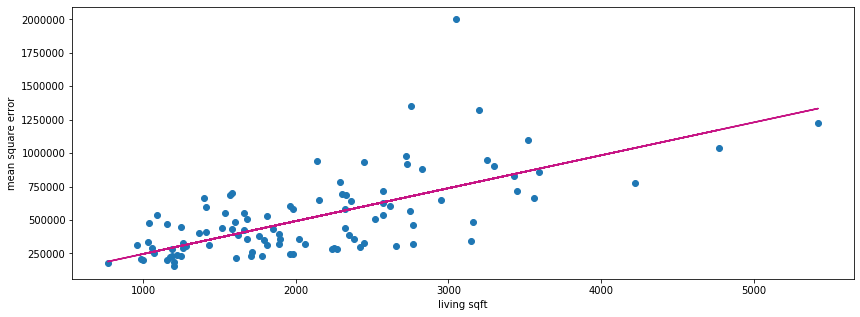

In [6]:
min_costs = np.min(costs)
min_b1_index = costs.index(min_costs)
min_b1 = b1s[min_b1_index]

y_predicted = predict(min_b1, X)
plt.figure(figsize=(14,5))
plt.xlabel('living sqft')
plt.ylabel('mean square error')
plt.scatter(X,y,)
plt.plot(X, y_predicted, 'mediumvioletred')

print("Best b1: {}, mse: {}".format(min_b1[0], min_costs))

# 2. Bias

The line above has limitation of crossing point (0,0). As on our data it doesn't seem harmful, let us check how our model would perform, if all $y$ were shifted by some constant. The interpretation is as follows: the goverment has imposed a new tax in the set amount of 1 million dollar on buying new houses.

Best b1: 656, mse: 208030959040.45


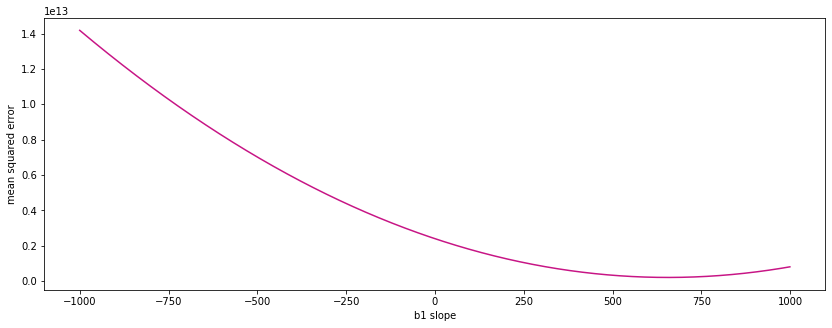

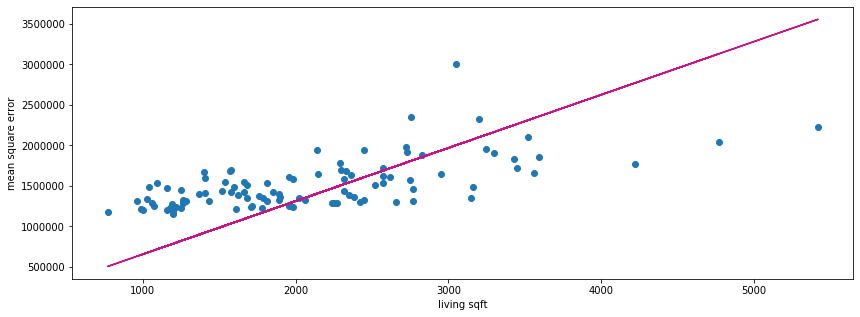

In [7]:
new_y = y + 1000000
b1s = [[i] for i in range(-1000, 1000)]
costs = [cost(predict(b1,X), new_y) for b1 in b1s]
plt.figure(figsize=(14,5))
plt.xlabel('b1 slope')
plt.ylabel('mean squared error')
plt.plot(b1s, costs, 'mediumvioletred')


min_costs = np.min(costs)
min_b1_index = costs.index(min_costs)
min_b1 = b1s[min_b1_index]

y_predicted = predict(min_b1, X)
plt.figure(figsize=(14,5))
plt.xlabel('living sqft')
plt.ylabel('mean square error')
plt.scatter(X, new_y,)
plt.plot(X, y_predicted, 'mediumvioletred')

print("Best b1: {}, mse: {}".format(min_b1[0], min_costs))

As we can see, for the best slope the error has grown almost by the factor of four. In addition we clearly see, that what limits us is indeed the constraint of all lines crossing point $(0,0)$.   

There are two basic solutions of this problem. One of them is centring of the data, that is substracting overall mean from all the values of given feature (or regressand).  

The other is adding bias term, which in this context (different than context discussed during the lectures!) may be understood as constant term in line equation. We simulate adding constant term to result of each prediction by appending artificial feature consisting of ones to **$X$** matrix and additional term to **$b$** vector.

## Exercise 2
a) Add bias column to the **$X$** matrix.  
b) Make the code below compatible with functions that you've created so far.

In [8]:
#a)
n, m = np.shape(X)
a = np.ones((n, m)).astype(int)
X_bias = np.append(X, a, axis=1)
# print(X_bias)

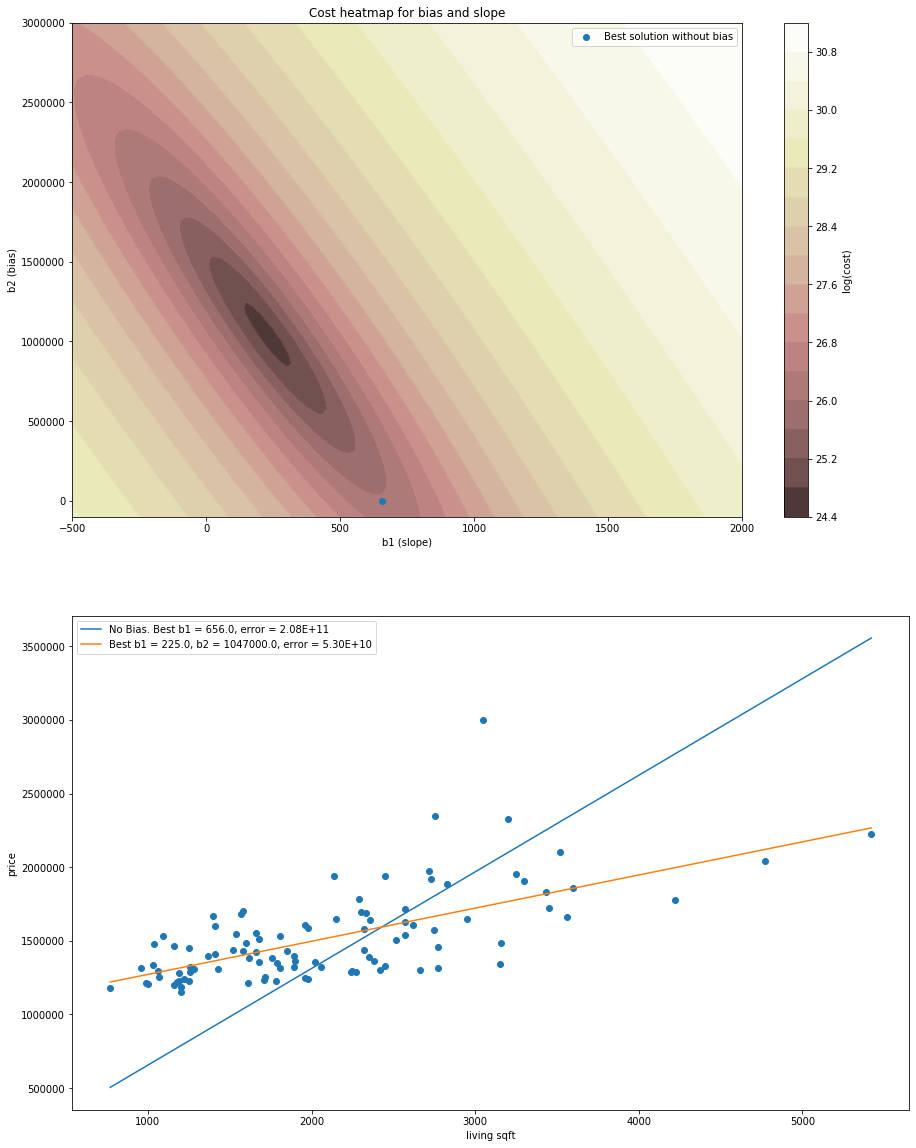

In [9]:
#b)
y_shifted = y+1e6

#No Bias Part
b_arr = [np.array(b1) for b1 in np.linspace(-1000, 1000, num=2001)]
# print(b_arr)
cost_arr = [cost(predict([b], X), y_shifted) for b in b_arr]
best_b1 = b_arr[np.argmin(cost_arr)]


#Bias Part
nb_of_bs = 101 # compute the cost nb_of_bs times in each dimension
b1 = np.linspace(-500, 2000, num=nb_of_bs) # slope coefficient
b2 = np.linspace(-1e5, 3e6, num=nb_of_bs) # bias
b_x, b_y = np.meshgrid(b1, b2) # generate grid
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs)) # initialize cost matrix

# Fill the cost matrix for each combination of coefficients
for i in range(nb_of_bs):
    for j in range(nb_of_bs):
        cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), X_bias) , y_shifted)


plt.figure(figsize=(15,20)) 
        
plt.subplot(2,1,1)
plt.title("Cost heatmap for bias and slope")

plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
plt.scatter(best_b1, 0, label = "Best solution without bias")
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")
plt.legend()

plt.subplot(2,1,2)

plt.scatter(X_bias.T[0], y_shifted)
plt.xlabel("living sqft")
plt.ylabel("price")

x_model = np.linspace(np.min(X), np.max(X), 1000)
y_model = best_b1*x_model
plt.plot(x_model, y_model, label='No Bias. Best b1 = {}, error = {:.2E}'.format(best_b1, cost_arr[np.argmin(cost_arr)]))

best_b1_2d_ind, best_b2_2d_ind = np.unravel_index(cost_arr_2d.argmin(), cost_arr_2d.shape)
best_b1 = b_x[best_b1_2d_ind,best_b2_2d_ind]
best_b2 = b_y[best_b1_2d_ind,best_b2_2d_ind]

y_model = best_b1*x_model + best_b2
plt.plot(x_model, y_model, label='Best b1 = {}, b2 = {}, error = {:.2E}'.format(best_b1, best_b2, cost_arr_2d[best_b1_2d_ind,best_b2_2d_ind]))

plt.legend()

plt.show()

**Adding bias improved error by three orders of magnitude. Not bad!**

# 3. Standardization

In order to improve performance of many machine learning algorithms, the value standardization is applied. It makes the values of each feature in the data have zero-mean and unit-variance. It is achieved by substracting from each value $x$ the overall mean $\bar{x}$, and then dividing it by feature's standard deviation ${\sigma}$:

$$x' = \frac{x - \bar{x}}{\sigma}. $$

It is important to remember, that bias column should not be standardize!

## Exercise 3
a) Implement function standardize(), which standardize the feature matrix and returns it together with two vectors containing original features' means and standard deviations.  
b) Implement function destandardize(), which restores the original data given standardized feature matrix X and vectors containing original features' means and standard deviations.  
c) Plot original $X,y$ data. Then plot it after standardization. Then plot it after destandardisation.

In [10]:
#a)
def standardize(X):
    mean = np.mean(X, axis=0)
    standard_deviation = np.std(X, axis=0)
    standarized_X = np.array([[(x - mean[i])/ standard_deviation[i] for i, x in enumerate(row)] for row in X])
    return standarized_X, mean, standard_deviation

#b)
def destandardize(X, means, sds):
    return np.array([[x * standard_deviation[i] + mean[i] for i, x in enumerate(row)] for row in X])


#short test:
W = [[1,2,3],[2,5,4],[3,4,5],[4,5,7]]
standarized_X, mean, standard_deviation = standardize(W)
print("Standarized X :{}".format(standarized_X))
print("Means : {}".format(mean))
print("Standard deviations : {}".format(standard_deviation))

destadarized = destandardize(standarized_X, mean, standard_deviation)
print("Destandarized: {}".format(destadarized))

#Hint: with np.mean and np.std first function is three lines long. The second is one-liner.

Standarized X :[[-1.34164079 -1.63299316 -1.18321596]
 [-0.4472136   0.81649658 -0.50709255]
 [ 0.4472136   0.          0.16903085]
 [ 1.34164079  0.81649658  1.52127766]]
Means : [2.5  4.   4.75]
Standard deviations : [1.11803399 1.22474487 1.47901995]
Destandarized: [[1. 2. 3.]
 [2. 5. 4.]
 [3. 4. 5.]
 [4. 5. 7.]]


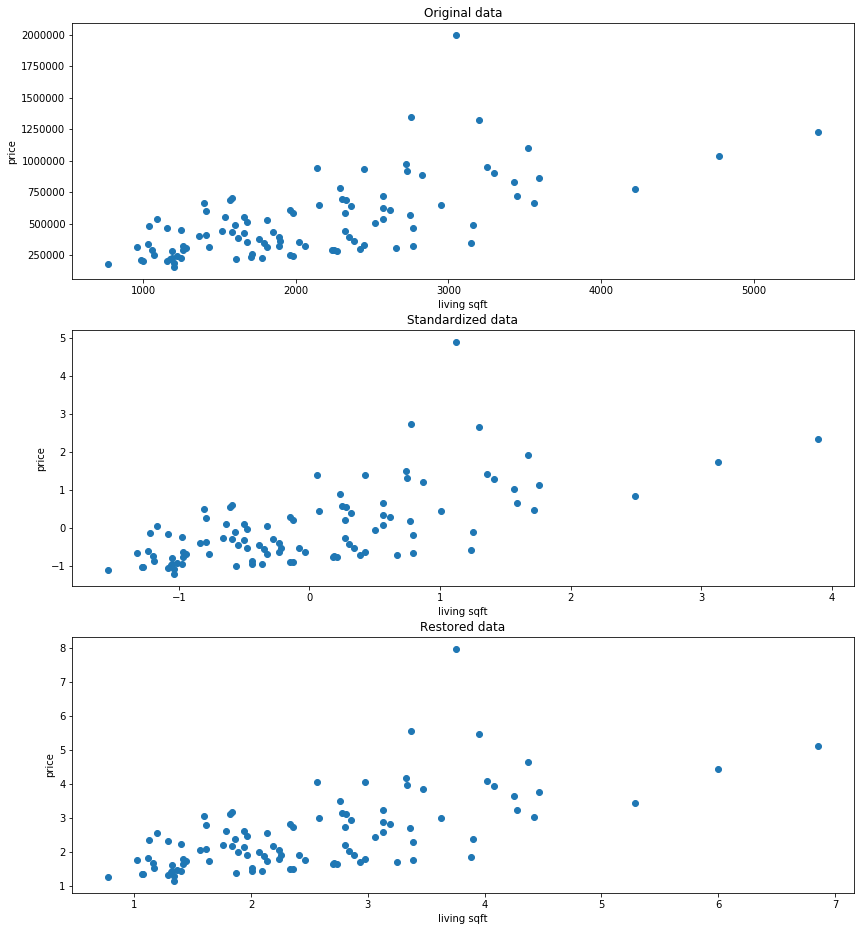

In [11]:
#c)
plt.figure(figsize=(14,16))
plt.subplot(311)
plt.title("Original data")
plt.xlabel("living sqft")
plt.ylabel("price")
plt.scatter(X, y)

plt.subplot(312)
plt.title("Standardized data")
plt.xlabel("living sqft")
plt.ylabel("price")
standarized_X, mean_x, standard_deviation_x = standardize(X.tolist())
standarized_y, mean_y, standard_deviation_y = standardize(y.tolist())
plt.scatter(standarized_X, standarized_y)

plt.subplot(313)
plt.title("Restored data")
plt.xlabel("living sqft")
plt.ylabel("price")
destandarized_X = destandardize(standarized_X, mean_x, standard_deviation_x)
destandarized_y = destandardize(standarized_y, mean_y, standard_deviation_y)
plt.scatter(destandarized_X, destandarized_y)

## 3. Gradient Descent Method

In previous examples we were determining the approximate value of optimal vector **$b$** by finding best arguments from pre-defined grid. This solution is neither fast nor precise. Although in theory it is possible to find vector **$b$** analytically, it requires inversing large matrices, as the close form for **$b$** is $b=(X^\mathsf{T}X)^{-1}X^\mathsf{T}y$.

The other approach is to find approximation of **$b$** is Gradient Descent Method. Let us recall that for function $f: \ R^n \to R$ a gradient 

$$\nabla f =  \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \vdots \\ \frac{\partial f}{\partial x_n} \end{bmatrix}$$

is the direction of the biggest increase of $f$. Using linearity of derivative, $-\nabla f$ is the direction of the biggest decrease. Gradient Descent Method is based on iterative moving in the direction opposite to gradient, and by these means approaching the minimum.

#### GDM step by step:  
1. Choose starting point $x_{0}$ and parameters: *learning rate* and *precision*,
2. Update $x_{i+1} = x_{i} - \nabla f(x_{i})\cdot lr$, where $lr$ is learning rate parameter,
3. If $(|\nabla f(x_{i})| < precision)$, end. If not, go back to point 2.

One of many limitations of GMD may be knowledge of function's gradient. Luckily for us, it is quite easy in case of linear regression with mean square error cost function. We have

$$ \nabla f_{y}(b) = \nabla\dfrac{|Xbây|^2}{n} = \dfrac{2X^\mathsf{T}(Xbây)}{n}.  $$

## Exercise 4
a) Create functions: *gradient()* which computes gradient for linear regresion and *gradient_descent_step()* which returns new vector **b** being the result of one GDM step.  

b) Take **$X$** consisting of *sqft_living* together with bias column. Set **$y$** as price. Standardize both **$X$** (without bias) and **$y$**. Plot a heatmap showing dependence of cost function's value on vector **$b$**. Mark first 5 steps of gradient descent with *learning rate* = $0.2$, starting from **$b =  \begin{bmatrix} 3 \\ 2 \end{bmatrix}$**. Experiment with other *learning rates*.  

c) Take **$X$** consisting of *sqft_living* and *sqft_lot*. Set **$y$** as price. Standardize both **$X$** and **$y$**. Plot a heatmap showing dependence of cost function's value on vector **$b$**. Mark first 5 steps of gradient descent with *learning rate* = $0.2$, starting from **$b =  \begin{bmatrix} 3 \\ 1 \end{bmatrix}$**. Experiment with other *learning rates*.  

d) Try to redo above points without standarization. How can you explain such results?


In [73]:
#a)

# def gradient(b, X, y):
    
#     diff = (X @ b - y)
#     return np.dot(2*X.T, diff) / X.shape[0]

def gradient(b, X, y):
    n = float(len(X))
    X_t = 2*X.transpose()
    Xb = np.subtract(np.dot(X,b), y)
    gradient = np.divide(np.dot(X_t,Xb), n)
    return gradient

def gradient_descent_step(b, X, y, lr):
    grad = gradient(b, X, y)
    b = b.astype(float)
    return np.array([b[i] - grad[i]*lr for i in range(len(b))])


#short test:
test_b = np.array([[1],[1],[1]])
test_X = np.array([[1,2,3],[2,5,4],[3,4,5],[4,5,7]])
test_y = np.array([[1],[2],[3],[4]])

print(gradient(test_b, test_X, test_y))
print(gradient_descent_step(test_b, test_X, test_y, 0.1))

[[49. ]
 [75.5]
 [90. ]]
[[-3.9 ]
 [-6.55]
 [-8.  ]]


In [85]:
def plot_color_map(X, Y,lin_arg=((-4, 4), (-4, 4))):
    nb_of_bs = 101 # compute the cost nb_of_bs times in each dimension
    b1 = np.linspace(lin_arg[0][0], lin_arg[0][1], num=nb_of_bs) # slope coefficient
    b2 = np.linspace(lin_arg[1][0], lin_arg[1][1], num=nb_of_bs) # bias
    b_x, b_y = np.meshgrid(b1, b2) # generate grid
    cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs)) # initialize cost matrix
    # Fill the cost matrix for each combination of coefficients
    for i in range(nb_of_bs):
        for j in range(nb_of_bs):
            cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), X) , Y)

    plt.figure(figsize=(15,20))         
    plt.subplot(2,1,1)
    plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
    cbar = plt.colorbar()

    
def perform_and_plot_gradient_descent(X, Y, b, lr, n_steps=5):
    w = [[],[]]
    w[0].append(b[0]), w[1].append(b[1])
    plt.scatter(b[0], b[1], color='mediumvioletred')
    plt.annotate("w0", (b[0],b[1]), horizontalalignment='right', verticalalignment='bottom')
    new_b = b
    for i in range(n_steps):
        new_b = gradient_descent_step(new_b, X, Y, lr)
        plt.scatter(new_b[0], new_b[1], color='mediumvioletred')
        plt.annotate("w{}".format(i+1), (new_b[0],new_b[1]), horizontalalignment='right', verticalalignment='bottom')
        w[0].append(new_b[0]), w[1].append(new_b[1])
    plt.plot(w[0], w[1])


Text(0, 0.5, 'b2 (bias)')

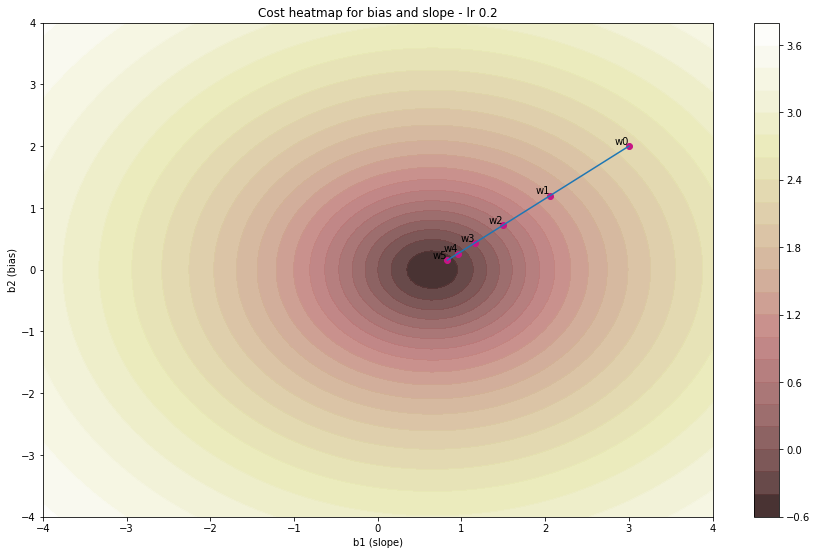

In [86]:
# b)
stand_X, m, s = np.asarray(standardize(X))
stand_y, _, _ = np.asarray(standardize(y))

n, m = np.shape(stand_X)
a = np.ones((n, m)).astype(int)
X_bias = np.append(stand_X, a, axis=1)
# print("X bias: {}".format(X_bias))
# print("y standarized: {}".format(stand_y))

b = np.array([[3], [2]])
lr = 0.2
plot_color_map(X_bias, stand_y)
plt.title("Cost heatmap for bias and slope - lr 0.2")
perform_and_plot_gradient_descent(X_bias, stand_y, b, lr)

cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")

Text(0, 0.5, 'b2 (bias)')

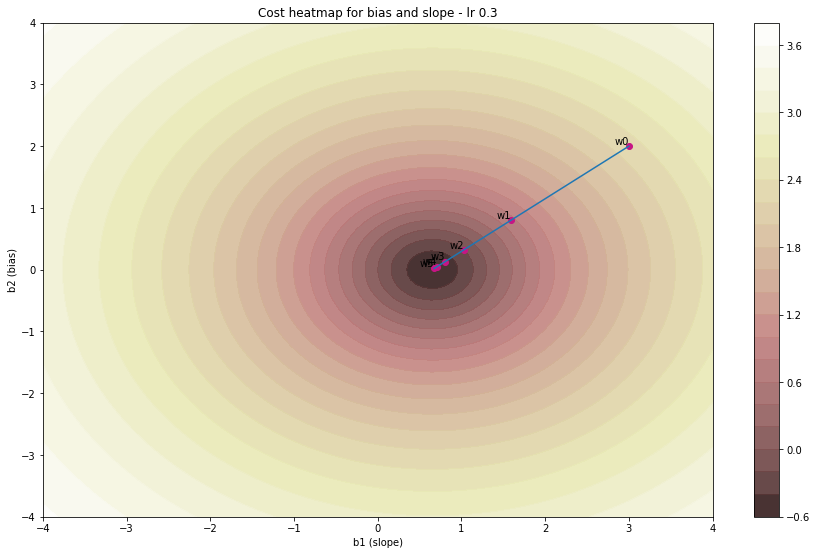

In [49]:
b = np.array([[3], [2]])
lr = 0.3
plot_color_map(X_bias, stand_y)
plt.title("Cost heatmap for bias and slope - lr 0.3")
perform_and_plot_gradient_descent(X_bias, stand_y, b, lr)

cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")

Text(0, 0.5, 'sqft lot weight')

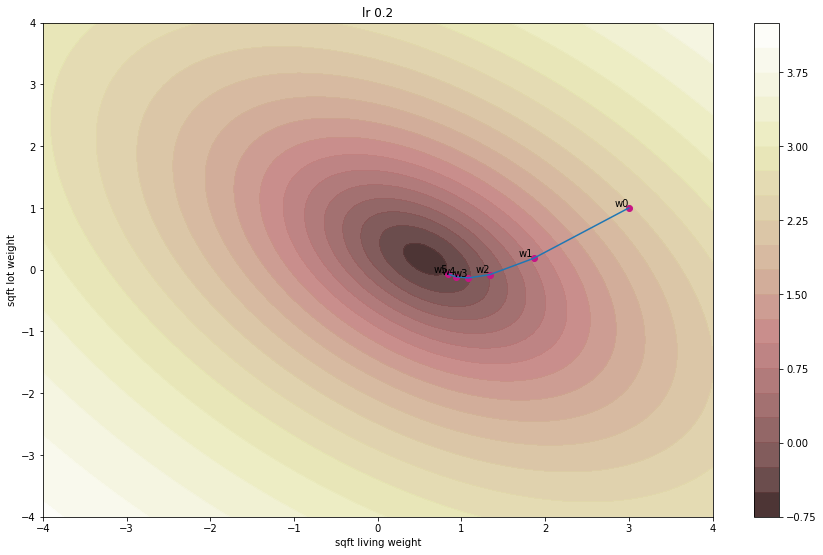

In [76]:
# c)

sqft_living = house_df.sqft_living.values.reshape(-1,1)[:100]
sqft_lot = house_df.sqft_lot.values.reshape(-1,1)[:100]
_X = np.append(sqft_living, sqft_lot, axis=1)
_stand_X, m, s = np.asarray(standardize(_X))

b = np.array([[3], [1]])
lr = 0.2
plot_color_map(_stand_X, stand_y)

plt.title("lr 0.2")
perform_and_plot_gradient_descent(_stand_X, stand_y, b, lr)

cbar.ax.set_ylabel('log(cost)')
plt.xlabel("sqft living weight")
plt.ylabel("sqft lot weight")


Text(0, 0.5, 'sqft lot weight')

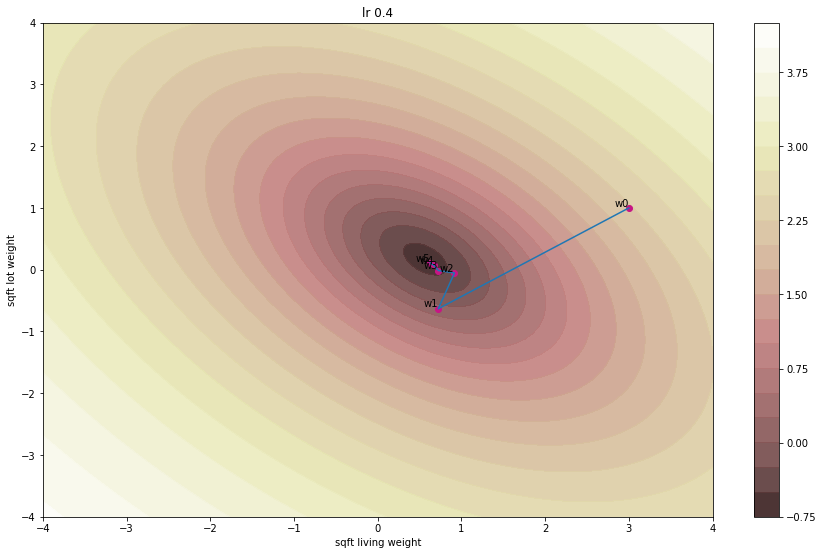

In [77]:
lr = 0.4
plot_color_map(_stand_X, stand_y)

plt.title("lr 0.4")
perform_and_plot_gradient_descent(_stand_X, stand_y, b, lr)

cbar.ax.set_ylabel('log(cost)')
plt.xlabel("sqft living weight")
plt.ylabel("sqft lot weight")



Text(0, 0.5, 'b2 (bias)')

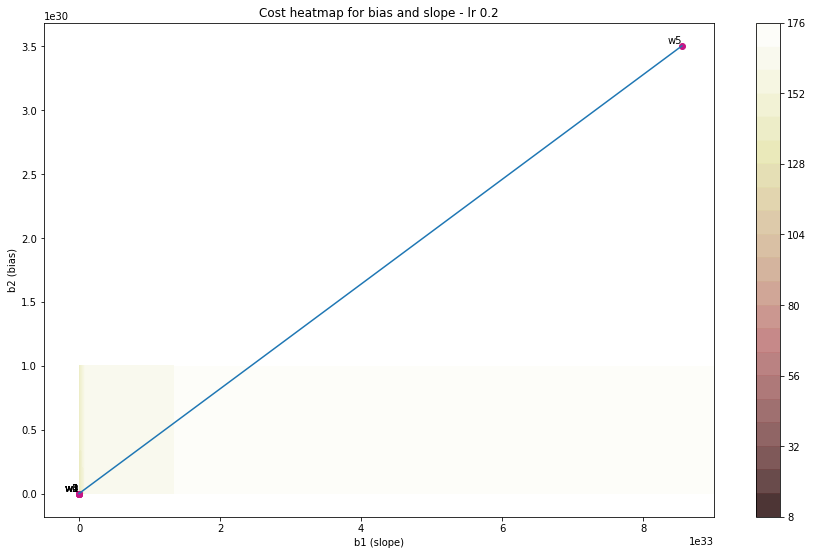

In [88]:
#d)

# b without standarization
n, m = np.shape(X)
a = np.ones((n, m)).astype(int)
X_bias = np.append(X, a, axis=1)

b = np.array([[3], [2]])
lr = 0.2
plot_color_map(X_bias, stand_y,((-1, 9 * 1e33), (0, 1e30)))
plt.title("Cost heatmap for bias and slope - lr 0.2")
perform_and_plot_gradient_descent(X_bias, y, b, lr)

cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")